In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from loguru import logger
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_data():
    """Unpack data"""
    stock = pd.read_csv("data/stock_data.csv")[["date", "ticker", "open" , "high", "low", "close"]]
    stock["date"] = pd.to_datetime(stock["date"])
    tickets = pd.read_csv("data/ticker_info.csv", index_col= 0)
    return stock, tickets

def calculate_mfm(data):
    data["mfm"] = ((data["close"] - data["low"]) - (data["high"] - data["close"]))*100/(data["high"] - data["low"])
    data.loc[data["mfm"].isna(), "mfm"] = 0.0
    return data

def calc_strategy(stock, low = -99.9, high = 99.9):
    stock["signal"] = np.nan
    stock_numpy = stock.to_numpy()
    for index in range(2, len(stock)):
        if (stock_numpy[index, 6] <= low) & (stock_numpy[index - 1, 6] > low) & (stock_numpy[index - 2, 6] > low):
            stock_numpy[index, 7] = "buy"
        elif (stock_numpy[index, 6] >= high) & (stock_numpy[index - 1, 6] < high) & (stock_numpy[index - 2, 6] < high):
            stock_numpy[index, 7] = "sell"
    return pd.DataFrame(stock_numpy, columns = stock.columns)

def plot_signals(data, ticker_name):
    figure(figsize=(15, 3), dpi=80)
    data_with_signals = data[~data["signal"].isna()].to_dict(orient='records')
    for row in data_with_signals:
        if row["signal"] == "buy":
            plt.plot(row["date"], row["close"],'ro', color='green')
        elif row["signal"] == "sell":
            plt.plot(row["date"], row["close"],'ro', color='red')
    plt.plot(data["date"], data["close"], color = "black")
    plt.xlabel("date")
    plt.ylabel("close")
    plt.title(f"Buy and sell dots of {ticker_name}")
    
def test_strategy(stock):
    sum_history = []
    number_history = []
    start_sum = stock_with_signals.close.mean()*10
    logger.info(f'Start sum: {round(start_sum, 2)}')
    number_of_stocks = 0
    for index, row in stock.iterrows():
        if row["signal"] == "buy" and start_sum >= row["close"]:
            number_of_stocks += 1
            start_sum -= row["close"]
            # no shorts! :)
        elif row["signal"] == "sell" and number_of_stocks > 0:
            number_of_stocks -= 1
            start_sum += row["close"]
        sum_history.append(start_sum + number_of_stocks*row["close"])
        number_history.append(number_of_stocks)
    final_price = stock_with_signals.close.iloc[-1]
    sum_history[-1]+=final_price*number_of_stocks
    start_sum+=final_price*number_of_stocks
    number_history[-1] = 0
    fig, axs = plt.subplots(2, 1, figsize=(15, 6))
    axs[0].plot(stock_with_signals["date"], sum_history)
    axs[0].set_xlabel('time')
    axs[0].grid(True)
    axs[0].set_title(f"""ticker {stock_with_signals.ticker.loc[0]}, absolute grouth of start stock {round(100*(sum_history[-1]/sum_history[0]-1), 2)}%""")    
    axs[1].plot(stock_with_signals["date"], number_history)
    axs[1].set_xlabel('time')
    axs[1].grid(True)
    axs[1].set_title(f"""Number of stocks""") 
    fig.tight_layout()
    plt.show()
    logger.info(f'Sharp ration: {get_sharp_ratio(stock)}')
    logger.info(f'In the end we have {number_of_stocks} stocks, start sum: {round(sum_history[0], 2)}, end sum: {round(start_sum, 2)}')

def get_sharp_ratio(stock):
    stock_with_signals["daily_return"] = stock_with_signals["close"].pct_change(1)
    Sharpe_Ratio = stock_with_signals["daily_return"].mean() / stock_with_signals["daily_return"].std()
    return round(Sharpe_Ratio, 5)
    

In [3]:
stock, tickers = get_data()

2022-07-31 20:33:10.324 | INFO     | __main__:test_strategy:40 - Start sum: 150.42


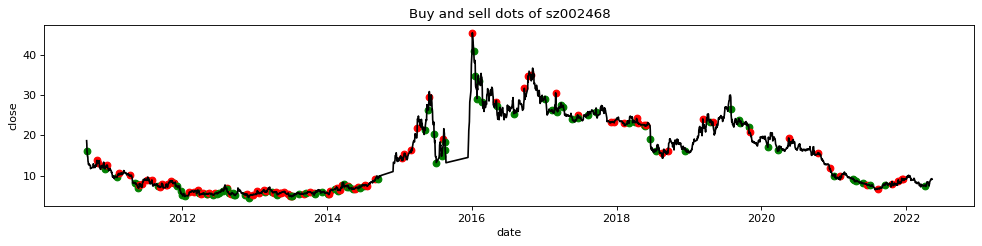

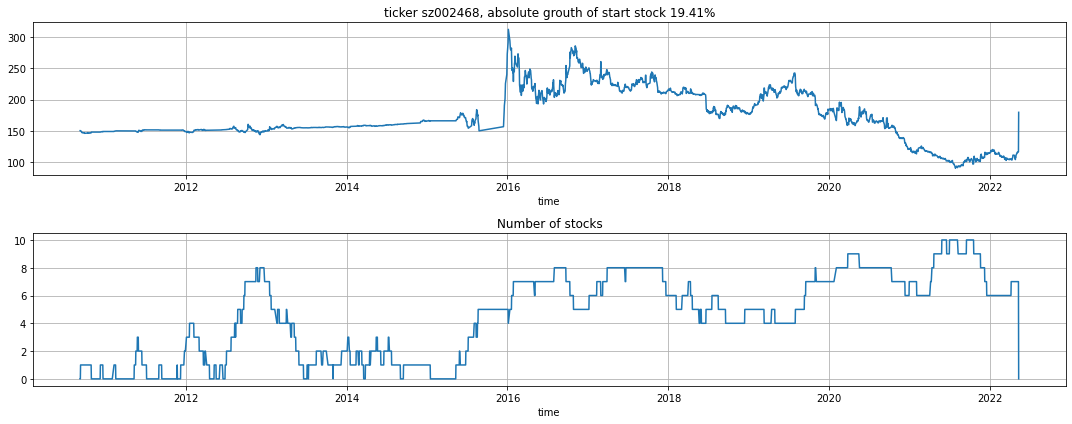

2022-07-31 20:33:10.696 | INFO     | __main__:test_strategy:67 - Sharp ration: 0.00566
2022-07-31 20:33:10.697 | INFO     | __main__:test_strategy:68 - In the end we have 7 stocks, start sum: 150.42, end sum: 116.06


In [4]:
# ticker_name = list(stock.ticker.sample(1).items())[0][1]
ticker_name = "sz002468"

single_comp = stock[stock["ticker"]==ticker_name] 
stock_with_mfm = calculate_mfm(single_comp)
stock_with_signals = calc_strategy(stock_with_mfm)
plot_signals(stock_with_signals, ticker_name = ticker_name)
test_strategy(stock_with_signals)